In [1]:
import numpy as np
import sympy as sp
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats, optimize
import seaborn as sns
import arviz as az
import xarray as xr

config = {
    'figure.facecolor':'w',
    'axes.grid':True,
    'axes.spines.top':False,
    'axes.spines.bottom':False,
    'axes.spines.left':False,
    'axes.spines.right':False,
    'grid.linewidth':0.5,
    'grid.linestyle':'--',
    'figure.constrained_layout.use':True
}

plt.rcParams.update(config)

# Section 1 - Analytic Expressions

Consider the portfolio $p$ composed with two stocks, $a$ and $b$. We use the usual notations:
- $r_i$, the return associated to the stock or the portfolio $i$;
- $\mu_i$, the expected return of the stock or the portfolio $i$;
- $\sigma_i^2$, the return variance of the stock or the portfolio $i$;
- $\sigma_{i,j}$, the covariance between the returns of the stock $i$ and $j$;
- $x_i$, the part of the portfolio invested in the stock $i$.

## Question 1

Write an algebraic expression of the return associated to the portfolio p, according to the returns of the individual stocks

We saw last week that the returns of a portfolio build from two assets is just a weighted combination of the returns of the two assets. That is, given portfolio weights $x$, the returns of the portfolio $r_p$ is:

$$r_p = x r_a + (1 - x) r_b$$

## Question 2

Write an algebraic expression of the expected return of the portfolio according to $\mu_a$ and $\mu_b$.


Now we need to know the [convolution of two normals](https://www.youtube.com/watch?v=IaSGqQa5O-M) formula. Given $X \sim N(\mu_x, \sigma^2_y)$ and $Y \sim N(\mu_y, \sigma^2_y)$, a new random variable $Z = X + Y$ will be distributed:

$$Z \sim N(\mu_x + \mu_y, \sigma^2_x + \sigma^2_y + 2\sigma_{x,y})$$

Knowing this formula answers question 2 and 3, we just have to also use the shifting-scaling formula, because we're not adding together $a + b$, we're adding together $xa + (1 - x)b$. Thus, the mean will be:

$$\mu_p = x\mu_a + (1 - x)\mu_b$$

## Question 3

The distribution of a shifted normal $Z = aX$, where $X \sim N(\mu_x, \sigma^2_x)$ is $Z \sim N(x\mu_x + x^2\sigma^2_x)$. 

Pattern matching, the variance of the portfolio will be:

$$\sigma^2_p = x^2\sigma_a^2 + (1-x)^2\sigma_b^2 + 2 x (1 - x) \sigma_{a,b}$$

### Numerical checks

We can draw some random variables and check that all this math works out.

In [2]:
# I just made these numbers up
μ_a = 0.1
μ_b = 0.05

σ2_a = 0.05
σ2_b = 0.01
ρ = 0.1

# Correlation matrix
C = np.array([[1, ρ],
              [ρ, 1]])
# Diagonal matrix of stds
σ = np.diag([σ2_a ** 0.5, σ2_b ** 0.5])

# This is a way to alwas get a valid covariance matrix
# (it's harder than you think to just pick one)
Σ = σ @ C @ σ.T
σ_ab = Σ[0, 1]

# Since the stocks are correlated, we draw them jointly from a 
# multivariate normal
d = stats.multivariate_normal(mean=np.r_[μ_a, μ_b], cov=Σ)

# Get a bunch of samples
samples = d.rvs(1_000_000)

# Transform the samples into the portfolio
x = 0.5
p = x * samples[:, 0] + (1 - x) * samples[:, 1]

In [3]:
print(f'Sample portfolio mean: {p.mean():0.3f}')
print(f'Analytical portfolio mean: {x * μ_a + (1 - x) * μ_b:0.3f}')

Sample portfolio mean: 0.075
Analytical portfolio mean: 0.075


In [4]:
print(f'Sample portfolio variance: {p.var():0.3f}')
print(f'Analytical portfolio variance: {x**2 * σ2_a + (1 - x) ** 2 * σ2_b + 2 * x * (1 - x) * σ_ab:0.3f}')

Sample portfolio variance: 0.016
Analytical portfolio variance: 0.016


## Question 3

In the case of perfect correlation, prove that the standard deviation can be written:

$$\sigma_p = x \sigma_a + (1 - x) \sigma_b$$

I thought first it might be nice to visualize what it means to have perfectly correlated assets. Let's draw some samples from such a distribution

In [5]:
# I just made these numbers up
μ_a = 0.1
μ_b = 0.05

σ2_a = 0.05
σ2_b = 0.01

# ρ = 1 is perfect correlation
ρ = 1

# Correlation matrix
C = np.array([[1, ρ],
              [ρ, 1]])
# Diagonal matrix of stds
σ = np.diag([σ2_a ** 0.5, σ2_b ** 0.5])

# This is a way to alwas get a valid covariance matrix
# (it's harder than you think to just pick one)
Σ = σ @ C @ σ.T
σ_ab = Σ[0, 1]

print('Covariance Matrix:')
with np.printoptions(precision=3):
    print(Σ)

Covariance Matrix:
[[0.05  0.022]
 [0.022 0.01 ]]


Nothing looks odd (to me) when I look at the covariance matrix. Let's draw some samples:

In [6]:
# Since the stocks are correlated, we draw them jointly from a 
# multivariate normal
d = stats.multivariate_normal(mean=np.r_[μ_a, μ_b], cov=Σ, allow_singular=True)

# Get a bunch of samples
samples = d.rvs(100_000)
x = 0.5
p = x * samples[:, 0] + (1 - x) * samples[:, 1]

Correlations are 1, as requested

In [7]:
np.corrcoef(samples.T)

array([[1., 1.],
       [1., 1.]])

Plotting the samples, we see that they're on a straight line. Remember that this is a **joint** distribution, so we're drawing 2 numbers at a time. Since the correlation is 1, whatever the first number is, the 2nd number is a __deterministic function__ of it, and vice-versa.

Another way to say it: if we know one of the numbers, we know the other one with 100% certainty.

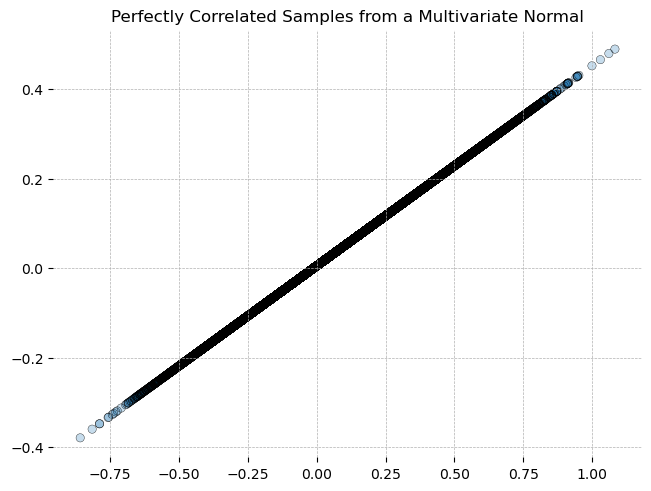

In [8]:
fig, ax = plt.subplots()
ax.scatter(*samples.T, facecolor='tab:blue', edgecolor='none', alpha=0.25)
ax.scatter(*samples.T, facecolor='none', edgecolor='k', lw=0.25)

ax.set_title('Perfectly Correlated Samples from a Multivariate Normal')
plt.show()

Anyway, this is all just intuition building. To answer the actual question, we need to use an the fact that $\sigma_{a,b} = \rho \sigma_a \sigma_b$. 

Fun fact: this is also the fact we used to make the covariance matrix in the code. Do this matrix multiplication and see what you get on the off diagonal entries:

$$\Sigma = \begin{bmatrix}\sigma_a^2 & 0 \\ 0 & \sigma_b^2 \end{bmatrix} \begin{bmatrix} 1 & \rho \\ \rho & 1 \end{bmatrix} \begin{bmatrix}\sigma_a^2 & 0 \\ 0 & \sigma_b^2 \end{bmatrix}^T$$

Double anyway, plug in to the variance equation:

$$\sigma^2_p = x^2 \sigma^2_a + (1 - x)^2 \sigma^2_b + 2 \rho x (1 - x)\sigma_a \sigma_b$$

Plug in $\rho = 1$:

$$\sigma^2_p = x^2 \sigma^2_a + (1 - x)^2 \sigma^2_b + 2 x (1 - x) \sigma_a \sigma_b$$

Now you notice that this is the square of the sum of two numbers, that is, $(a + b)^2 = a^2 + b^2 + 2ab$, with $a=x\sigma_a$ and $b = (1-x)\sigma_b$, so write:

$$\sigma^2_p = (x \sigma_a + (1 - x)\sigma_b)^2$$

Square root on both sides and you're done!

$$\sigma_p = x \sigma_a + (1 - x) \sigma_b$$


In [9]:
print(f'Sample portfolio std: {p.std():0.3f}')
print(f'Analytical portfolio std: {x * σ2_a ** 0.5 + (1 - x) * σ2_b ** 0.5:0.3f}')

Sample portfolio std: 0.162
Analytical portfolio std: 0.162


## Question 5

Show that it is possible to build a free risk portfolio with two risky assets, whose returns are perfectly correlated.

Let's go back to our samples from the perfectly correlated assets. We saw on the plot that it was a line, but what is the line? Let's plot it again along with a 45-degree line:

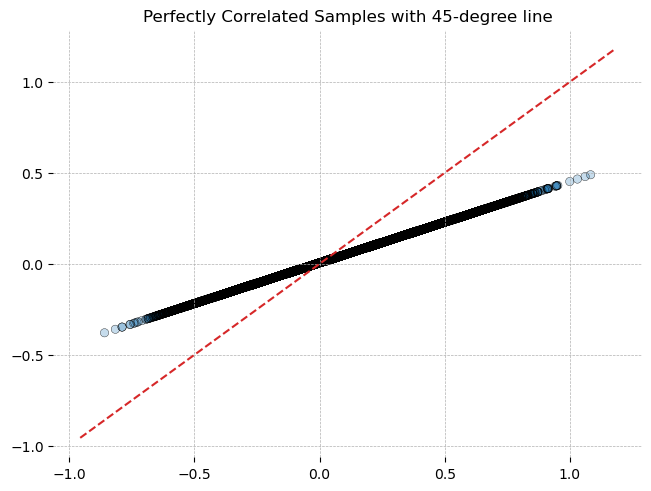

In [10]:
fig, ax = plt.subplots()
ax.scatter(*samples.T, facecolor='tab:blue', edgecolor='none', alpha=0.25)
ax.scatter(*samples.T, facecolor='none', edgecolor='k', lw=0.25)

xmin, xmax = ax.get_xlim()
x_grid = np.linspace(xmin, xmax, 100)
ax.plot(x_grid, x_grid, color='tab:red', ls='--')
ax.set_title('Perfectly Correlated Samples with 45-degree line')
plt.show()

So the slope is less than 1, but what is it? We can compute the slope a lot of different ways, but I'll just run a regression.

As expected, the slope is positive and less than 1.

In [11]:
slope, intercept = np.polyfit(samples[:, 0], samples[:, 1], deg=1)
print(f'Regrssion slope: {slope:0.3f}')

Regrssion slope: 0.447


Plot it again to confirm we didn't make any mistakes

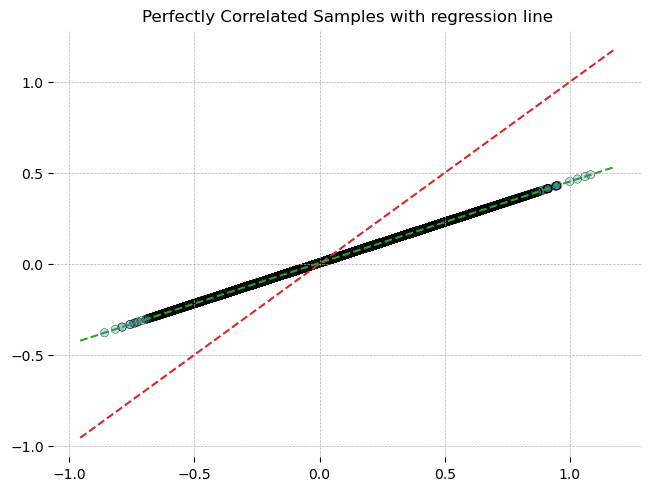

In [12]:
fig, ax = plt.subplots()
ax.scatter(*samples.T, facecolor='tab:blue', edgecolor='none', alpha=0.25)
ax.scatter(*samples.T, facecolor='none', edgecolor='k', lw=0.25)

xmin, xmax = ax.get_xlim()
x_grid = np.linspace(xmin, xmax, 100)

ax.plot(x_grid, x_grid, color='tab:red', ls='--')
ax.plot(x_grid, intercept + x_grid * slope, color='tab:green', ls='--')

ax.set_title('Perfectly Correlated Samples with regression line')
plt.show()

So now we know the relationship between the assets. How does this help us build a risk-free portfolio?

When we build a portfolio, we get to choose the portfolio weight. To get a risk-free portfolio, the distribution of the portfolio should be strictly positive. So our task to to choose a weight that makes the distribution of the portfolio returns strictly positive.

Let's plot the distribution of a couple portfolios:

In [13]:
portfolios = {}
for weight in np.arange(0, 1.1, 0.1):
    p = weight * samples[:, 0] + (1 - weight) * samples[:, 1]
    portfolios[f'{weight:0.2f}'] = p
df = pd.DataFrame(portfolios)

Here I plot distributions of the portfolios for each different value of $x$. None of them are risk free, because there is non-zero probability of negative returns.

So, in strictly long positions (that is $x \geq 0$), we're not able to make a risk-free portfolio. What about if we consider long-short positions, where $x <0$?

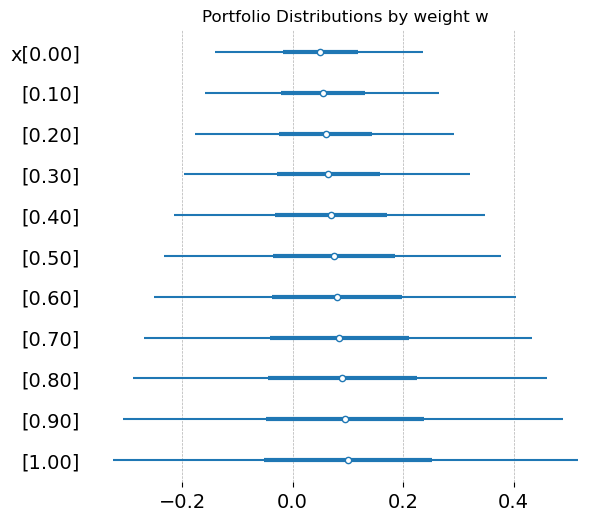

In [14]:
ax = az.plot_forest(xr.DataArray(df.values[None], 
                            dims=['chain', 'draw', 'weight'],
                            coords={'weight':df.columns}))[0]
ax.set_title('Portfolio Distributions by weight w')
plt.show()

In [15]:
portfolios = {}
for weight in np.arange(0, -1.1, -0.1):
    p = weight * samples[:, 0] + (1 - weight) * samples[:, 1]
    portfolios[f'{weight:0.2f}'] = p
df = pd.DataFrame(portfolios)

As we increase the size of the short position on asset a, we seem to be converging to a risk-free portfolio! The variance is decreasing, and the mean is converging to a single value.

The magic value seems to be around 0.8.

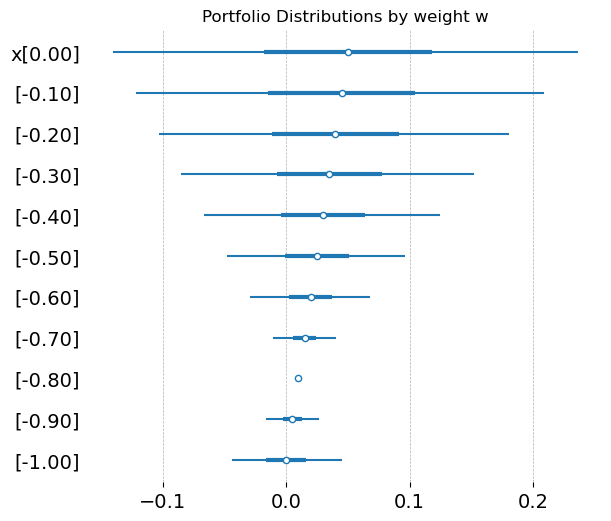

In [16]:
ax = az.plot_forest(xr.DataArray(df.values[None], 
                            dims=['chain', 'draw', 'weight'],
                            coords={'weight':df.columns}))[0]
ax.set_title('Portfolio Distributions by weight w')
plt.show()

We can try to pin down the mean a bit more scientifically by looking at the variance of the portfolio as a function of the weights.

In [17]:
def portfolio_var(weight, samples):
    p = weight * samples[:, 0] + (1 - weight) * samples[:, 1]
    return p.var()

def portfolio_mean(weight, samples):
    p = weight * samples[:, 0] + (1 - weight) * samples[:, 1]
    return p.mean()

In [18]:
means = []
variances = []
weights = np.arange(-1, 1.1, 0.1)
for weight in weights:
    means.append(portfolio_mean(weight, samples))
    variances.append(portfolio_var(weight, samples))

I'll also use a numerical optimizer to find the minimum variance weight. You can see that it finds a minimum (`success: True`), that the minimum weight is -0.809 (`x: -0.809016...`), and that the value of the variance at that weight is zero (`fun: 1.622e-19`).

This confirms that it's possible to build a portfolio with zero variance!

In [19]:
res = optimize.minimize_scalar(portfolio_var, bracket=[-1, 1], args=samples)
res

 message: 
          Optimization terminated successfully;
          The returned value satisfies the termination criteria
          (using xtol = 1.48e-08 )
 success: True
     fun: 1.616969994296965e-19
       x: -0.8090169943717628
     nit: 5
    nfev: 8

As we saw in the forest plot, the mean at the zero variance weights is positive. This is indeed a risk-free portfolio!

In [20]:
print(f'Expected return at w=-0.809: {portfolio_mean(res.x, samples):0.3f}')

Expected return at w=-0.809: 0.010


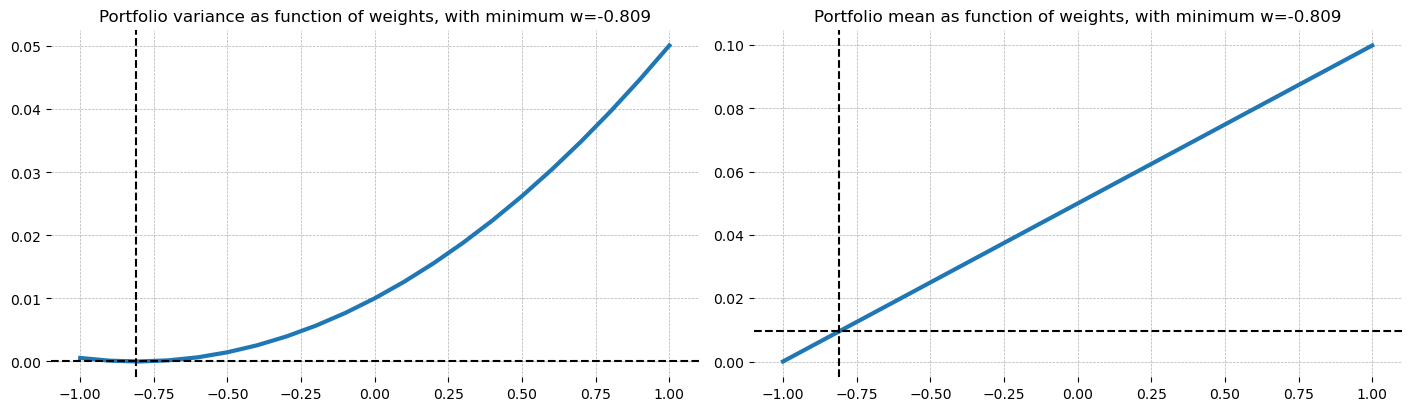

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
ax[0].plot(weights, variances, lw=3)
ax[0].axvline(res.x, ls='--', c='k')
ax[0].axhline(portfolio_var(res.x, samples), ls='--', c='k')
ax[0].set_title(f'Portfolio variance as function of weights, with minimum w={res.x:0.3f}')

ax[1].plot(weights, means, lw=3)
ax[1].axvline(res.x, ls='--', c='k')
ax[1].axhline(portfolio_mean(res.x, samples), ls='--', c='k')
ax[1].set_title(f'Portfolio mean as function of weights, with minimum w={res.x:0.3f}')

plt.show()

So now let's bring it all together. What's the optimal **ratio**, $\frac{x}{1 - x}$?

In [22]:
res.x / (1 - res.x)

-0.44721359549898476

In [23]:
slope

0.44721359549898443

It's exactly the (negative) slope of the line the returns sat on.

If you remember from econometrics class, a regression coefficient for a univariate regression $y = \alpha + \beta  x + \varepsilon$ can be written as $\beta = \frac{\sigma_{x,y}}{\sigma^2_y}$, i.e. the fraction of variation in $\sigma_y$ which can be explained by the covariance between x and y.

We can also write this as:

$$\beta = \frac{\sigma_{x,y}}{\sigma^2_y} = \frac{\rho \sigma_c \sigma_y}{\sigma^2_y} = \frac{\rho \sigma_x}{\sigma_y}$$

And since $\rho = 1$ in this case:

$$\beta = \frac{\sigma_x}{\sigma_y}$$

In [24]:
# Covariance over variance
σ_ab / σ2_a

0.4472135954999579

In [25]:
# corr * std / std
(σ2_b / σ2_a) ** 0.5

0.4472135954999579

How can we find this result analytically? Let's choose $w$ in order to minimize the variance of our portfolio. That is:

$$\min_{w} w^2 \sigma^2_a + (1 - w)^2 \sigma_b^2  + 2 \rho w (1 - w) \sigma_a \sigma_b$$

Take the derivative and set it equal to zero, then solve for w:

$$ \begin{align}
2w \sigma^2_a - 2(1 - w) \sigma_b^2 - 2 \rho w \sigma_a \sigma_b + 2 \rho (1 - w) \sigma_a \sigma_b &= 0 \\
2w \sigma^2_a - 2(1- w) \sigma_b^2 + 2 \rho \sigma_a \sigma_b (1 - 2w) &= 0 \\
w \sigma^2_a - (1- w) \sigma_b^2 + \rho \sigma_a \sigma_b (1 - 2w) &= 0 \\
w \sigma^2_a - \sigma_b^2 + w \sigma_b^2 + \rho \sigma_a \sigma_b - 2w \rho \sigma_a \sigma_b &= 0 \\
w \sigma^2_a + w \sigma_b^2 - 2w \rho \sigma_a \sigma_b &= \sigma_b^2 - \rho \sigma_a \sigma_b \\
w (\sigma^2_a + \sigma_b^2 - 2 \rho \sigma_a \sigma_b) &= \sigma_b^2 - \rho \sigma_a \sigma_b \\
w &= \frac{\sigma_b^2 - \rho \sigma_a \sigma_b}{\sigma^2_a + \sigma_b^2 - 2 \rho \sigma_a \sigma_b}
\end{align}$$ 

Given two normally distributed assets, this formula will always give us the minimum variance portfolio build from those two assets. 

If $\rho = 1$, we can do more simplification:

$$\begin{align}
w &= \frac{\sigma_b^2 - \sigma_a \sigma_b}{\sigma^2_a + \sigma_b^2 - 2 \sigma_a \sigma_b}
\end{align}$$

Notice that the bottom is $(\sigma_a - \sigma_b)^2$, so:

$$\begin{align}
w &= \frac{\sigma_b (\sigma_b - \sigma_a)}{(\sigma_a - \sigma_b)^2}\\
  &= -\frac{\sigma_b (\sigma_a - \sigma_b)}{(\sigma_a - \sigma_b)^2} \\
  &= -\frac{\sigma_b}{\sigma_a - \sigma_b}
\end{align}$$

Tada!

Check this formula against the optimizer solution:

In [26]:
def zero_variance_weight(σ_a, σ_b):
    return -σ_b / (σ_a - σ_b)

zero_variance_weight(σ2_a ** 0.5, σ2_b ** 0.5)

-0.8090169943749476

In [27]:
res.x

-0.8090169943717628

### Aside: Back to the regression connection

And we can also recover the relationship between the slope of the regression line and the optimal weights by computing checking that $\frac{w}{(1 - w)} = -\frac{\sigma_b}{\sigma_a}= -\beta$:

$$\begin{align}
\frac{w}{(1 - w)} &= -\frac{\sigma_b}{\sigma_a - \sigma_b} \left ( 1 + \frac{\sigma_b}{\sigma_a - \sigma_b} \right )^{-1} \\
&= -\frac{\sigma_b}{\sigma_a - \sigma_b} \left ( \frac{\sigma_a - \sigma_b}{\sigma_a - \sigma_b} + \frac{\sigma_b}{\sigma_a - \sigma_b} \right )^{-1}\\
&= -\frac{\sigma_b}{\sigma_a - \sigma_b} \left ( \frac{\sigma_a}{\sigma_a - \sigma_b} \right )^{-1}\\
&= -\frac{\sigma_b}{\sigma_a - \sigma_b} \left ( \frac{\sigma_a - \sigma_b}{\sigma_a} \right )\\
&= -\frac{\sigma_b}{\sigma_a} = -\beta
\end{align}$$

### Aside over: Proof that the portfolio is risk free

So we got $w^\star = -\frac{\sigma_b}{\sigma_a - \sigma_b}$, but that's just a formula for the minimum variance portfolio. We need to actually prove that it's going to always be zero variance. We can do this by computing $\sigma_p(w^\star)$

Before we start, it's good to know that $1 - w = \frac{\sigma_a}{\sigma_a - \sigma_b}$, and $w (1 - w) = -\frac{\sigma_a \sigma_b}{(\sigma_a - \sigma_b)^2}$, I'm going to use that right away.

$$\begin{align}
\sigma_p &= w^2 \sigma^2_a + (1 - w)^2 \sigma_b^2  + 2 w (1 - w) \sigma_a \sigma_b \\
&= \left(-\frac{\sigma_b}{\sigma_a - \sigma_b} \right)^2 \sigma^2_a + \left(\frac{\sigma_a}{\sigma_a - \sigma_b} \right)^2 \sigma_b^2  - 2 \frac{\sigma_a \sigma_b}{(\sigma_a - \sigma_b)^2} \sigma_a \sigma_b \\
&= \frac{\sigma_b^2 \sigma_a^2}{(\sigma_a - \sigma_b)^2} + \frac{\sigma_a^2 \sigma_b^2}{(\sigma_a - \sigma_b)^2} - 2 \frac{\sigma_a^2 \sigma_b^2}{(\sigma_a - \sigma_b)^2} \\
&= 2 \frac{\sigma_b^2 \sigma_a^2}{(\sigma_a - \sigma_b)^2} - 2 \frac{\sigma_a^2 \sigma_b^2}{(\sigma_a - \sigma_b)^2} \\
\sigma^2_p &= 0
\end{align}$$

### Proof that returns are positive

The last thing to do is prove that returns under this portfolio are strictly positive. Just plug and chug:

$$
\begin{align}
\mu_p &= w\mu_a + (1 - w)\mu_b \\
&= \frac{\sigma_a}{\sigma_a - \sigma_b}\mu_b - \frac{\sigma_b}{\sigma_a - \sigma_b}\mu_a\\
\mu_p &= \frac{\sigma_a \mu_b - \sigma_b \mu_a}{\sigma_a - \sigma_b} \\
\end{align}
$$

Let's quickly check this formula against the optimizer solution

In [28]:
# Optimizer solution
portfolio_mean(res.x, samples)

0.009549150282170925

In [29]:
# Analytic formula
def zero_risk_returns(μ_a, μ_b, σ_a, σ_b):
    return (σ_a * μ_b - σ_b * μ_a) / (σ_a - σ_b)

zero_risk_returns(μ_a, μ_b, σ2_a ** 0.5, σ2_b ** 0.5)

0.009549150281252614

So when are the zero-risk portfolio returns positive? Write it as an inequality and solve for a condition:

$$
\begin{align}
\frac{\sigma_a}{\sigma_a - \sigma_b}\mu_b - \frac{\sigma_b}{\sigma_a - \sigma_b}\mu_a > 0\\
\frac{\sigma_a}{\sigma_a - \sigma_b}\mu_b > \frac{\sigma_b}{\sigma_a - \sigma_b}\mu_a
\end{align}
$$

Remark: is $\sigma_a - \sigma_b$ ever negative? On one hand yes, because if $\sigma_b > \sigma_a$ it's negative. But on the other hand, the labels of which asset is $a$ and which is $b$ is totally up to us. Let's say that we **always choose the lower variance asset as $b$**. In that case, $\sigma_a - \sigma_b > 0$, so we can divide it away from the above inequality:

$$
\begin{align}
\sigma_a\mu_b > \sigma_b \mu_a \\
\frac{\sigma_a}{\sigma_b} > \frac{\mu_a}{\mu_b}
\end{align}
$$

In the last line I divided by $\sigma_b$ and $\mu_b$. Assume that the expected return of both assets are strictly positive (otherwise what are we doing investing in it?). To ensure that the zero-variance portfolio has positive returns, we require the ratio of the standard deviations to be larger than the ratio of the means.


In [30]:
# Numerical check!
σ_a = 0.5
σ_b = 0.4

μ_a = 2
μ_b = 1

print(f'σ_a / σ_b = {σ_a / σ_b}')
print(f'μ_a / μ_b = {μ_a / μ_b}')

# Here we have σ_a / σ_b < μ_a / μ_b, so the returns for the 
# zero-variance portfolio should be negative.

σ_a / σ_b = 1.25
μ_a / μ_b = 2.0


We can see that in this case, the zero-variance portfolio gives negative returns.

In [31]:
w_star = zero_variance_weight(σ_a, σ_b)
r_star = zero_risk_returns(μ_a, μ_b, σ_a, σ_b)
print(f'Return at zero variance: {r_star:0.2f}')

Return at zero variance: -3.00


Could we make the returns positive by just switching the labels?

In [32]:
#notice that i type in the argumnets backwards
r_star_flipped = zero_risk_returns(μ_b, μ_a, σ_b, σ_a)
print(f'Return at zero variance, flipped: {r_star_flipped:0.2f}')

Return at zero variance, flipped: -3.00


## Question 6

Is short selling necessary to build the risk-free portfolio?

We got an answer to this question en passant. Assume $\frac{\sigma_a}{\sigma_b} > \frac{\mu_a}{\mu_b}$, so we get a positive return. We know the optimal weight is:

$$w^\star = -\frac{\sigma_b}{\sigma_a - \sigma_b}$$

Remember that we decided to always sort the assets so that $\sigma_a > \sigma_b$. Thus, $w^\star$ is always negative, and we need to short sell to make this portfolio.

OK fine you say, but what if we flipped assets a and b, so that $\sigma_b > \sigma_a$? In that case we know that $\sigma_b > \sigma_b - \sigma_a$ (because $\sigma_a > 0$ and $\sigma_b > \sigma_a$), which in turn implies $w^\star = \frac{\sigma_b}{\sigma_b - \sigma_a} > 1$. That means that $1 - w^\star < 0$, so we still have to short!

## Question 7

Is the expected return of this portfolio between $\mu_a$ and $\mu_b$? 

We previously found that:
$$\mu^\star_p = w^\star \mu_a + (1 - w^\star) \mu_b$$

This will be between $\mu_a$ and $\mu_b$ if $w^\star \in [0, 1]$ (think about why).

For that to be the case, we need:

$$0 \leq -\frac{\sigma_b}{\sigma_a - \sigma_b} \leq 1$$

Just on the face of it, this is impossible, since it's not true that 0 is less than a negative number! Thus, we never have $w^\star \in [0, 1]$, and thus never have $\mu_p \in [\mu_a, \mu_b]$


If we sort the other way, this argument will still hold. In that case, we have:

$$0 \leq \frac{\sigma_b}{\sigma_b - \sigma_a} \leq 1$$

Which implies that $\sigma_a \leq \sigma_a + \sigma_b \leq \sigma_b$. While it's true that $\sigma_a \leq \sigma_a + \sigma_b$, it is a contradiction that $\sigma_a + \sigma_b \leq \sigma_b$, which proves the initial assumption was false.

# Section 2: Algebraic Resolution

In [33]:
data = np.array([[0.09, 0.04],
                 [0.16, 0.06]])
df = pd.DataFrame(data, index=['Asset 1', 'Asset 2'], columns=['mean', 'std'])
df

,mean,std
Asset 1,0.09,0.04
Asset 2,0.16,0.06


## Question 1: 

Compute the return and risk associated to a two asset portfolio of weights `w = {0.2, 0.4, 0.6, 0.8, 1.0}`, given the following correlations 

In [34]:
w_values = np.arange(0, 1.2, 0.2)
w_values

array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

Our job is to use the two formulas we derived above:

$$\begin{align} \mu_p &= w \mu_a + (1 - w) \mu_b \\
\sigma^2_p &= w ^2 \sigma_a^2 + (1 - w)^2 \sigma_b^2 + 2 \rho w (1 - w) \sigma_a \sigma_b
\end{align}$$

In [35]:
def portfolio_mean(mu_a, mu_b, w):
    return w * mu_a + (1 - w) * mu_b

def portfolio_var(sigma_a, sigma_b, w, rho):
    a_part = w ** 2 * sigma_a ** 2
    b_part = (1 - w) ** 2 * sigma_b ** 2
    cross_part = 2 * rho * w * (1 - w) * sigma_a * sigma_b
    return a_part + b_part + cross_part

### Expected Returns

Recall that the expected return doesn't depend on the correlation, so here's the means for everything:

In [36]:
mu_ans = pd.DataFrame(np.c_[w_values, portfolio_mean(*df['mean'].values, w_values)],
             columns=['weight', 'E[r]']).set_index('weight')
mu_ans

,E[r]
weight,
0.0,0.160
0.2,0.146
0.4,0.132
0.6,0.118
0.8,0.104
1.0,0.090


Sanity check: with $w=0$, the return is equal to asset 2's return (yes). When $w=1$, the return si equal to asset 1's return (yes).

### Volitilities

Now we get a matrix of risks, one per combination of wight and rho

In [37]:
rho_values = np.array([1, -1, 0, -0.5, 0.5])

In [38]:
answers = portfolio_var(*df['std'].values, w_values, rho_values[:, None]) ** 0.5
ans_df = pd.DataFrame(answers, index=rho_values, columns=w_values)
ans_df.index.name = 'ρ'
ans_df.columns.name = 'weight'
ans_df.T.sort_index(ascending=False)

ρ,1.0,-1.0,0.0,-0.5,0.5
weight,,,,,
1.0,0.040,0.04,0.040000,0.040000,0.040000
0.8,0.044,0.02,0.034176,0.028000,0.039395
0.6,0.048,0.00,0.033941,0.024000,0.041569
0.4,0.052,0.02,0.039395,0.031241,0.046130
0.2,0.056,0.04,0.048662,0.044542,0.052460
0.0,0.060,0.06,0.060000,0.060000,0.060000


Sanity checks:

1. When w=0 or w=1, it doesn't matter what rho is (yes)
2. When w=0, the std is equal to that of asset 2 (yes)
3. When w=1, the std is equal to that of asset 1 (yes)

We also know the zero variance formula is $w^\star = \frac{\sigma_b}{\sigma_b - \sigma_a}$. This case from setting $\rho=1$. If we set $\rho = -1$, instead we get $w^\star = \frac{\sigma_b}{\sigma_b + \sigma_a}$ (check it yourself!).

$$\frac{\sigma_b}{\sigma_b + \sigma_a} = \frac{0.06}{0.04 + 0.06} = 0.6$$

Indeed, we see the variance is zero when $w=0.6, \rho=-1$, so that's another sanity check.

## Question 2

Plot the portfolios in $(\sigma, \mu)$ space. Are they efficient (at each level of correlation)?

Here's the scatterplot of portfolios:

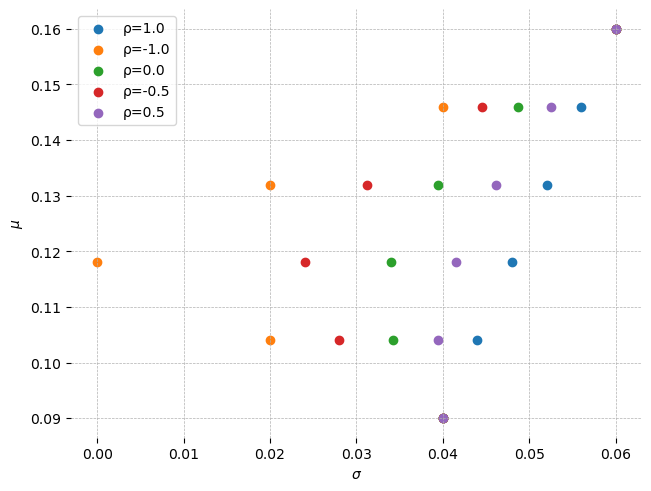

In [39]:
fig, ax = plt.subplots()
ans_df2 = (ans_df.melt(ignore_index=False, value_name='std')
           .merge(mu_ans, left_on='weight', right_index=True))
w_grid = np.linspace(0, 1, 100)
for i, rho in enumerate(rho_values):
    data = ans_df2.loc[rho]
    c = plt.cm.tab10(i)
    
    # Plot the portfolios for this rho 
    ax.scatter(data['std'], data['E[r]'], color=c, label=f'ρ={rho}')
ax.legend()
ax.set(xlabel=r'$\sigma$', ylabel=r'$\mu$')
plt.show()

To determine efficency, we need to work somewhat backwards. We want to know the weights that yield the best returns **for a fixed level of $\sigma$**. 


Basically, we want to choose weight $w$ to maximize $\mu_p$, subject to $\sigma^2_p$. Something like: 

$$\max_w w \mu_a + (1 - w) \mu_b, \quad \text{s.t.} \quad \sigma^2_p = w ^2 \sigma_a^2 + (1 - w)^2 \sigma_b^2 + 2 \rho w (1 - w) \sigma_a \sigma_b$$

Since there's only one control, we can just solve the constraint for the control and plug it into the objective. Notice, though, that the equation:

$$\sigma^2_p = w ^2 \sigma_a^2 + (1 - w)^2 \sigma_b^2 + 2 \rho w (1 - w) \sigma_a \sigma_b$$

Is quadratic in $w$, so we're going to have two solutions. Expand this expression out and set it equal to zero:

$$w ^2 \sigma_a^2 + \sigma_b^2 + w^2 \sigma_b^2 - 2w\sigma_b^2 + 2 \rho w \sigma_a \sigma_b - 2 \rho w^2 \sigma_a \sigma_b - \sigma_p^2 = 0$$

Collect like $w$ terms:

$$(\sigma_a^2 + \sigma_b^2 - 2 \rho \sigma_a \sigma_b)w ^2 + (2 \rho \sigma_a \sigma_b - 2 \sigma_b^2) w + (\sigma_b^2 - \sigma_p^2) = 0$$

This is a quadratic equation in $w$, of the form $aw^2 + bw + c = 0$. We remember that there are two solutions to such an equation, of the form:

$$w_{\sigma_p}^\star = \frac{-b \pm \sqrt{b^2 - 4ac}}{2a}$$

With:

$$\begin{align} a &= \sigma_a^2 + \sigma_b^2 - 2 \rho \sigma_a \sigma_b \\
                b &= 2 \rho \sigma_a \sigma_b - 2 \sigma_b^2 \\
                c &= \sigma_b^2 - \sigma_p^2
\end{align}
$$

So there are two branches to consider. When computing the optimal returns, we only want to look at the positive branch, because that will always be larger. But for plotting, to get the whole "sideways-U", we need both branches.

So taking the top branch, the best return you can get out of a portfolio at a given level of volatility is: 

$$\mu^\star_{\sigma_p} = \left (\frac{-b + \sqrt{b^2 - 4ac}}{2a} \right )\mu_a + (1 - \left (\frac{-b + \sqrt{b^2 - 4ac}}{2a} \right ) \mu_b$$

In [40]:
sa, sb, s_p = sp.symbols('sigma_a sigma_b sigma_p', real=True, positive=True)
w, ma, mb, l, r = sp.symbols('w mu_a mu_b lambda rho', real=True)

In [41]:
obj = w * ma + (1 - w) * mb
constraint = s_p ** 2 - (w ** 2 * sa ** 2 + (1 - w) ** 2 * sb ** 2 + 2 * r * w * (1 - w) * sa * sb) 

In [42]:
# Solve quadratic equation (two solutions)
w_solved =sp.solve(constraint, w)

# For each solution, plug into the objective 
mu_optim = [obj.subs({w:w_solution}) for w_solution in w_solved]

# Convert to python code we can use to plot
f_mu_optim = sp.lambdify([ma, mb, sa, sb, s_p, r], mu_optim)

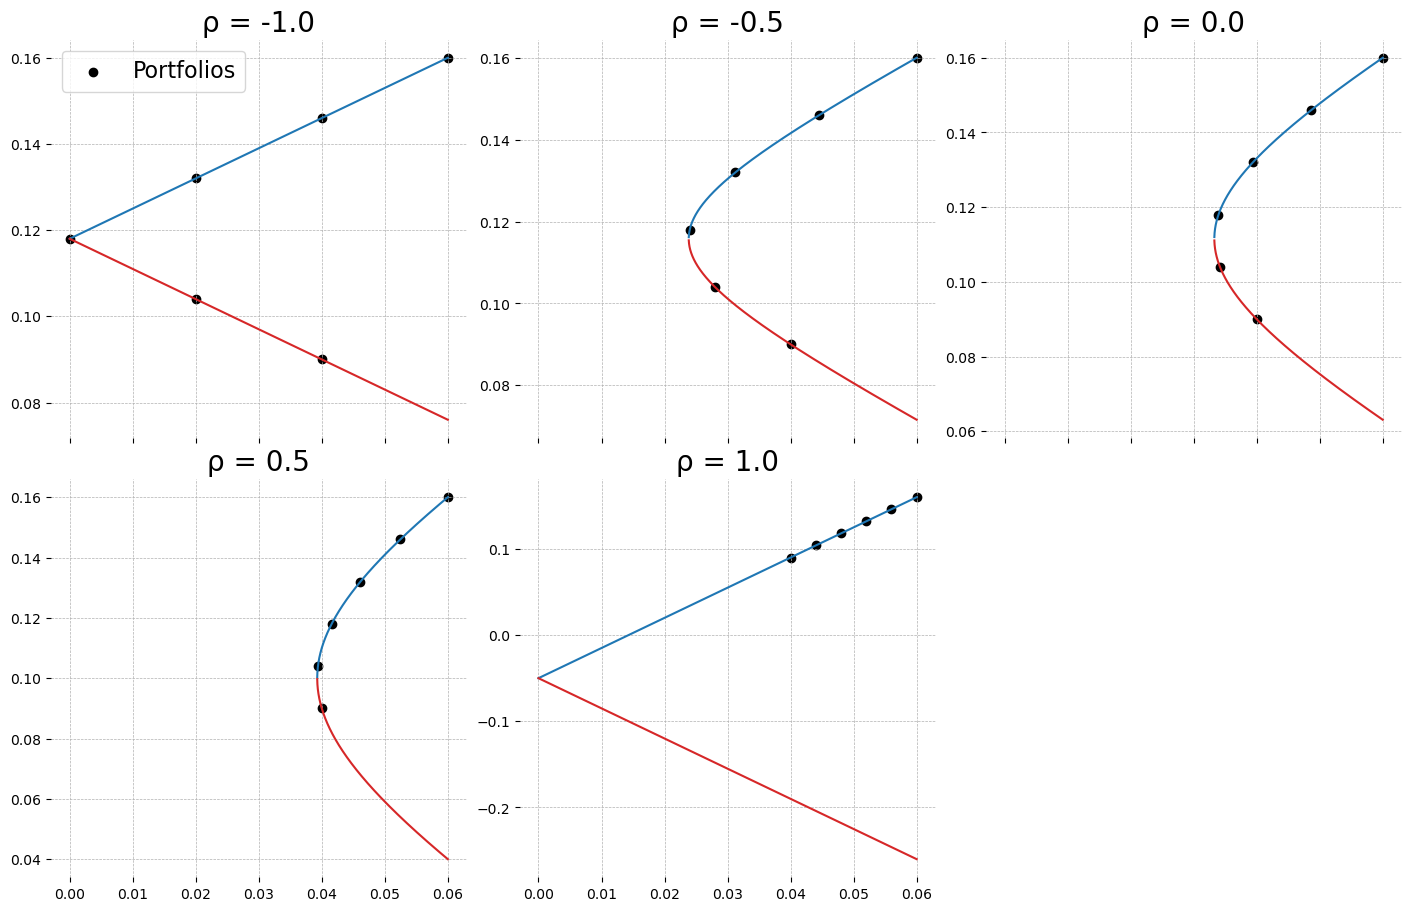

In [43]:
import warnings
import functools as ft

fig, ax = plt.subplots(2, 3, figsize=(14, 9), sharex=True)
sigma_grid = np.linspace(0, 0.06, 10000)

for rho, axis in zip(sorted(rho_values), fig.axes):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        
        mu_top, mu_bottom = f_mu_optim(*df.T.values.ravel(), sigma_grid, rho)
                
        axis.plot(sigma_grid, mu_top, c='tab:blue')
        axis.plot(sigma_grid, mu_bottom, c='tab:red')
        
        data = ans_df2.loc[rho]
        axis.scatter(data['std'], data['E[r]'], c='k', label='Portfolios')
        axis.set_title(f'ρ = {rho}', fontsize=20)
fig.axes[-1].set_visible(False)
fig.axes[0].legend(fontsize=16)
plt.show()

We can see that while all the portfolios we're considering are on the Mean-Efficient frontier, some of them are on the negative branch of the frontier, so we can do better. All the dots on the red section of the curve could be improved by jumping straight up to the blue curve, thereby increasing returns while holding the volatility fixed.

Also notice the effect of changing the correlation on the plots. At $\rho = 0$, it's a perfect sideways parabola. As $\rho \to \{1, -1\}$, it straightens out into a sideways absolute value plot 

## Question 3

We derived a generalized minimum-variance weight formula above. It was:


$$w = \frac{\sigma_b^2 - \rho \sigma_a \sigma_b}{\sigma^2_a + \sigma_b^2 - 2 \rho \sigma_a \sigma_b}$$

So we just plug $\rho = 0.5$ into this and we're done.

In [44]:
def w_star(σ_a, σ_b, rho):
    rab = rho * σ_a * σ_b
    numer = σ_b ** 2 - rab
    denom = σ_a ** 2 + σ_b ** 2 - 2 * rab
    
    return numer / denom


w_star_05 = w_star(*df['std'].values, 0.5)
sigma_p_05 = portfolio_var(*df['std'].values, w_star_05, 0.5)
mu_p_05 = portfolio_mean(*df['mean'].values, w_star_05)

print(f'Variance-Minimizing weight at ρ=0.5: {w_star_05:>10.5f}')
print(f'Var at ρ=0.5, w={w_star_05:0.3f}: {sigma_p_05:>24.5f}')
print(f'Mean at ρ=0.5, w={w_star_05:0.3f}: {mu_p_05:>23.5f}')

Variance-Minimizing weight at ρ=0.5:    0.85714
Var at ρ=0.5, w=0.857:                  0.00154
Mean at ρ=0.5, w=0.857:                 0.10000


## Question 4

Now introduce a risk-free asset with a return of 3%. We can represent portfolios built from a portfolio of risky assets and the riskless asset. These "portfolios of portfolios" will be line in the mean-volatility space, crossing the $\mu$ axis at $r_f = 0.03$ (because if we hold only risk-free asset, $\sigma = 0$ and $\mu=0.03$.

We need to determine the optimal weight of a portfolio comprised of a portfolio of risky assets with $\mu_m$ and $\sigma_m$, and $r_f$. We know this general formula:

$$w = \frac{\sigma_b^2 - \rho \sigma_a \sigma_b}{\sigma^2_a + \sigma_b^2 - 2 \rho \sigma_a \sigma_b}$$

But this isn't going to help us at all. If we try to set $\sigma_b = 0$ (because the riskless asset is asset b), we get $\frac{0}{\sigma^2_a} = 0$. This makes sense -- it's telling us that, to minimize variance, we should only buy the asset with no variance. Not helpful.

Let's think about the variance of the portfolio $\sigma_p$, built from the risky portfolio and the risk-free asset. Using the formula for variance, we get:

$$\sigma_p^2 = w^2 \sigma_m ^2 + (1 - w)^s \sigma_f^2 + 2 w (1 - w) \rho \sigma_m \sigma_f$$

Again, we know $\sigma_f = 0$. Plugging this in:

$$\sigma_p^2 = w^2 \sigma_m ^2$$

And solving for $w$ gives:

$$w = \frac{\sigma_p}{\sigma_m}$$

(Note how this solution relates to the regression coefficient discussion from above!)

What this is telling us is that we can deliver a target volatility $\sigma_p$ given any risky portfolio $\sigma_m$ by combining it with the risk free asset. 

The expected returns of the combined portfolio will be (following the formula):

$$\begin{align} \mu_p &= w \mu_m + (1 - w) \mu_f \\
                      &= \mu_f + w (\mu_m - \mu_f) \\
                      &= \mu_f + \frac{\sigma_p}{\sigma_m}(\mu_m - \mu_f) \\
                      &= \mu_f + \left ( \frac{\mu_m - \mu_f}{\sigma_m} \right ) \sigma_p
\end{align}
$$

Notice that this is a line in $\sigma_p, \mu_p$ space, and it doesn't depend at all on $w$! This line is called the **capital market line**. It says that we construct any portfolio described by $\mu_m, \sigma_m$, then deliver any returns $\mu_p$ for a desired $\sigma_p$.

One important feature of the capital market line is the slope:

$$\frac{\mu_m - \mu_f}{\sigma_m}$$

This is called the **Sharpe ratio** of an asset. It gives a measure of an asset's volatility adjusted excess return .

Because we are allowed to combine our two assets into a new asset (the portfolio), and combine that with the risk-free asset into another new asset, we need a way to measure which combination of the risky assets is best. The Sharpe ratio gives a way to do that. **The best portfolio of risky assets will be the one with the highest sharpe value**.

The maximum Sharpe portfolio has a special name: the **tangency portfolio**. 

To find the tangency portfolio, we seek weights $w$ to maximize the Sharpe ratio:

$$\max_w \frac{\mu_m - \mu_f}{\sigma_m}$$

We know that:

$$\begin{align}
\mu_m &= w \mu_a + (1 - w) \mu_b \\
\sigma_m &= \sqrt{w^2 \sigma_a^2 + (1 - w)^2 \sigma_b ^2  + 2 \rho w (1 - w) \sigma_a \sigma_b}
\end{align}$$

If we directly substitute into this it's going to get pretty messy, so I propose to first solve the for the derivatives symbolically, and put things together piece by piece. First, rewrite the Sharpe ratio to get rid of the fraction:

$$\max_w (\mu_m - \mu_f)\sigma_m^{-1}$$

Next, take the derivative of this and set it equal to zero, remembering that $\mu_m$ and $\sigma_m$ are functions of $w$. We will use the product rule:

$$-(\mu_m - \mu_f) \left ( \frac{\partial \sigma_m}{\partial w} \right ) ^{-2} + \frac{\partial \mu_m}{\partial w}\sigma_m^{-1}$$

I'm not going to lie: the algebra here is terrible. I'm just going to have the computer do it so we can talk about the answer

In [45]:
rf, sm, mm, mp = sp.symbols('r_f sigma_m mu_m, mu_p')
sharpe = (mm - rf) / sm 
cml = rf + sharpe * s_p

In [46]:
mm_subbed = w * ma + (1 - w) * mb
sm_subbed = sp.sqrt(w ** 2 * sa**2 + (1 - w) ** 2 * sb ** 2 + 2 * r * w * (1 - w) * sa * sb)

cml_subbed = cml.subs({mm:mm_subbed, sm:sm_subbed})
sharpe_subbed = sharpe.subs({mm:mm_subbed, sm:sm_subbed})
w_tan_star = sp.solve(sharpe_subbed.diff(w), w)[0]

In [52]:
w_tan_star_solved = w_tan_star.collect(sb ** 2).collect(sa * r).collect(sa ** 2)
f_w_tan = sp.lambdify([ma, mb, sa, sb, r, rf], w_tan_star_solved)
f_cml = sp.lambdify([s_p, ma, mb, sa, sb, r, rf], cml_subbed.subs({w:w_tan_star_solved}))
w_tan_star_solved

(rho*sigma_a*sigma_b*(mu_b - r_f) + sigma_b**2*(-mu_a + r_f))/(rho*sigma_a*sigma_b*(mu_a + mu_b - 2*r_f) + sigma_a**2*(-mu_b + r_f) + sigma_b**2*(-mu_a + r_f))

You see that we end up with excess returns everywhere, and that each term is multiplied by either a variance or covariance term. We also see that there's more terms on bottom than on top. So this is a ratio of variance weighted returns of both assets to the variance-weighted returns on assert A. 

We can plot the capital market line associated with the tangency portfolio on the mean-variance efficency plots we made earlier

In [53]:
print(f'Tangency portfolio weights for ρ = 0.5: {f_w_tan(*df.T.values.ravel(), 0.5, 0.03)}')

Tangency portfolio weights for ρ = 0.5: 0.3061224489795918


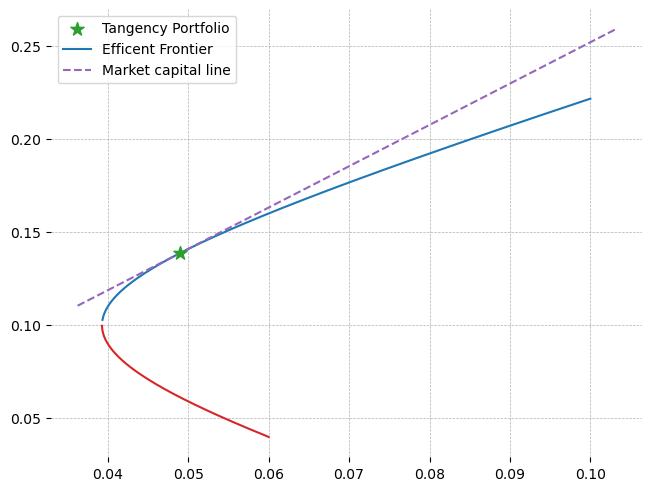

In [54]:
fig, ax = plt.subplots()
risk_free = 0.03
sigma_grid_top = np.linspace(0, 0.1, 1000)
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    mu_top, mu_bottom = f_mu_optim(*df.T.values.ravel(), sigma_grid, 0.5)
    mu_top = f_mu_optim(*df.T.values.ravel(), sigma_grid_top, 0.5)[0]
    w_tan_val = f_w_tan(*df.T.values.ravel(), 0.5, risk_free)
    var_tan = portfolio_var(*df['std'].values, w_tan_val, 0.5)
    mu_tan = portfolio_mean(*df['mean'].values, w_tan_val)

    ax.scatter(var_tan ** 0.5, mu_tan, s=100, zorder=100, marker='*', c='tab:green',
                 label='Tangency Portfolio')
    
ax.plot(sigma_grid_top, mu_top, c='tab:blue', label='Efficent Frontier')
ax.plot(sigma_grid, mu_bottom, c='tab:red')
xmin, xmax = ax.get_xlim()

sigma_grid_2 = np.linspace(xmin, xmax, 100)
ax.plot(sigma_grid_2, f_cml(sigma_grid_2, *df.T.values.ravel(), 0.5, risk_free),
        c='tab:purple', ls='--', label='Market capital line')
ax.legend()
plt.show()

Notice that, with the exception of the tangency portfolio itself, **all points on this capital market line are above the mean-variance efficiency boundary!**

Implication: **ALL** investors, no matter what their risk level, should buy the tangency portfolio. Then they should make a combination of that portfolio with the risk-free asset to achieve whatever risk-reward payoff they want. 

This is called the **two-fund theorem**.

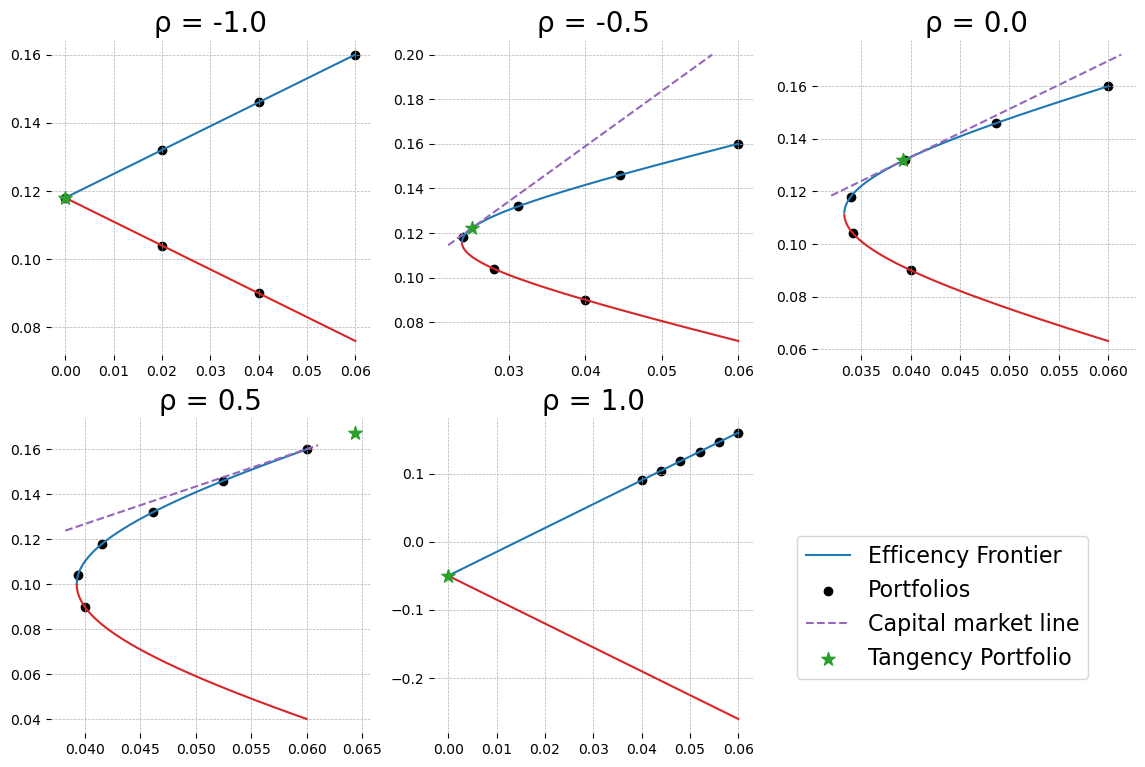

In [55]:
fig, ax = plt.subplots(2, 3, figsize=(14, 9))
sigma_grid = np.linspace(0, 0.06, 10000)
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    for rho, axis in zip(sorted(rho_values), fig.axes):

            mu_top, mu_bottom = f_mu_optim(*df.T.values.ravel(), sigma_grid, rho)

            axis.plot(sigma_grid, mu_top, c='tab:blue', label='Efficency Frontier')
            axis.plot(sigma_grid, mu_bottom, c='tab:red')

            data = ans_df2.loc[rho]
            axis.scatter(data['std'], data['E[r]'], c='k', label='Portfolios')
            xmin, xmax = axis.get_xlim()

            sigma_grid_2 = np.linspace(xmin, xmax, 10000)
            market_line = f_cml(sigma_grid_2, *df.T.values.ravel(), rho, 0.06)
            plot_subset = np.abs(market_line) < 0.2
            axis.plot(sigma_grid_2[plot_subset], 
                      market_line[plot_subset],
                      color='tab:purple', ls='--',
                      label='Capital market line')

            w_tan_val = f_w_tan(*df.T.values.ravel(), rho, 0.06)
            var_tan = portfolio_var(*df['std'].values, w_tan_val, rho)
            mu_tan = portfolio_mean(*df['mean'].values, w_tan_val)

            axis.scatter(var_tan ** 0.5, mu_tan, s=100, zorder=100, marker='*', c='tab:green',
                         label='Tangency Portfolio')

            axis.set_title(f'ρ = {rho}', fontsize=20)

    fig.axes[-1].set_visible(False)
    fig.axes[0].legend(fontsize=16, bbox_transform=fig.transFigure, loc='center left',
                       bbox_to_anchor=(0.65, 0.25))
    fig.tight_layout()
    plt.show()

## Question 5

How do you build a portfolio to get 5% returns?

The procedure is now always going to be the same. First, form the tangency portfolio. Then, pick a mix of tangency portfolio and risk-free asset that hits the desired returns. 

We previously found that the weights in the tangency portfolio are:

$$w_{\text{tan}} = \frac{\rho \sigma_{a} \sigma_{b} \left(\mu_{b} - r_{f}\right) + \sigma_{b}^{2} \left(- \mu_{a} + r_{f}\right)}{\rho \sigma_{a} \sigma_{b} \left(\mu_{a} + \mu_{b} - 2 r_{f}\right) + \sigma_{a}^{2} \left(- \mu_{b} + r_{f}\right) + \sigma_{b}^{2} \left(- \mu_{a} + r_{f}\right)}$$

So the return to the tangency portfolio will be:

$$\mu_{\text{tan}} = w_{\text{tan}}\mu_a + (1 - w_{\text{tan}}) \mu_b$$

Then we make the combined tangency + risk free portfolio, which will have return:

$$\mu_p = w_p \mu_{\text{tan}} + (1 - w_p) rf$$

For a desired $\mu_p$, we can solve this equation for $w_p$ to get:

$$w_p = \frac{\mu_p - rf}{\mu_{\text{tan}} - rf}$$

So we just plug and chug. Here's a numerical example for $\rho = 0.5$

In [56]:
# Get tangency weights
w_tan_val = f_w_tan(*df.T.values.ravel(), 0.5, risk_free)
w_tan_val

0.3061224489795918

In [57]:
# Compute mu_tan
mu_tan = (np.array([w_tan_val, 1 - w_tan_val]) * df['mean'].values).sum()
mu_tan

0.13857142857142857

In [58]:
# compute w_p to get a return of 0.05
w_p = (0.05 - risk_free) / (mu_tan - risk_free)
w_p

0.18421052631578952

Conclusion: We spend 18.42% of our wealth on the tangency portfolio, and the remaining 81.58% on the risk-free asset. The resulting portfolio delivers 5% returns, with at a lower variance than any portfolio we could construct using only the two risky assets.